In [ ]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize, wordpunct_tokenize, TreebankWordTokenizer, TweetTokenizer, MWETokenizer
from nltk.corpus import stopwords
from nltk import ngrams
import warnings
warnings.filterwarnings('ignore')
from nltk.stem import WordNetLemmatizer
import string
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
nltk.download('stopwords')
nltk.download('punkt')

import numpy as np
import pandas as pd

from collections import Counter
# from wordcloud import WordCloud
# import matplotlib.pyplot as plt
# import seaborn as sns

# print("\nStarting preprocessing\n")

train_corpus = pd.read_csv('project2_training_data.txt', delimiter='\r\n', header=None,names=['sentences'], engine='python')
train_labels = pd.read_csv('project2_training_data_labels.txt', delimiter='\r\n', header=None, names=['labels'], engine='python')

df = pd.concat([train_corpus, train_labels], axis=1)

pd.set_option('max_colwidth', 600)

# Corpus
def create_corpus(df):
    corpus = []
    
    for x in df['cleaned'].str.split():
        for i in x:
            corpus.append(i)
    return corpus


# Returns Top X frequent non stop words
def get_frequent_words(corpus, top_n=10):
    dic = dict()
    for word in corpus:
        if word in dic:
            dic[word] += 1
        else:
            dic[word] = 1

    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:top_n]

    return zip(*top)

def lemmatize(df):
    lemmatizer = WordNetLemmatizer()
    df['cleaned_lemmatized'] = df['cleaned'].apply(lambda x: ' '.join(lemmatizer.lemmatize(word) for word in word_tokenize(x)))
    return df

# Remove duplicates (3 in the given dataset)
dups = df[df.duplicated()]
df.drop_duplicates(inplace=True)
df.reset_index(drop = True, inplace= True)

# Remove stopwords
stops = set(stopwords.words('english'))

# Keep a few relevant stopwords
stopwords = list(set(stopwords.words("english")) - {"aren't", 'above', 'couldn', "couldn't", 'didn', "didn't",'doesn',"doesn't", 'don',"don't", 'below', 'before', 'down','hadn',
                                               "hadn't",'hasn',"hasn't", 'haven',"haven't","isn't", 'isn', 'mightn',"mightn't", 'mustn', "mustn't", 'needn', "needn't", 'more', 
                                               'further','from','no','nor','not', 'over', 'shan',"shan't", 'shouldn',"shouldn't", 'to','under', 'up','wasn',"wasn't",'weren',"weren't",
                                               'won',"won't",'wouldn', "wouldn't",})

# Remove punctuations, make lowercase
def clean_data(text, stopwords):
    tokens = word_tokenize(text.strip())
        
    lower = [i.lower() for i in tokens]
    
    clean = [j for j in lower if j not in stopwords]
    
    punctuations = list(string.punctuation) + ['+', '-', '*', '/']
    clean = [k.strip(''.join(punctuations)) for k in clean if k not in punctuations]
    if 's' in clean:
        clean.remove('s')
    return ' '.join(clean)

df['cleaned'] = df['sentences'].apply(lambda x: clean_data(x, stopwords))

labels = df.labels.values
data =df['cleaned'].values

# Create corpus of our data
corpus = create_corpus(df)

# Check most frequent words which are not in stopwords
counter = Counter(corpus)
most = counter.most_common()[:25]
x, y = [], []
for word, count in most:
    x.append(word)
    y.append(count)

# Plot the Word Cloud
# print("x:",x)
# print("y:",y)
# plt.figure(figsize=(15,15))
# plt.yticks(fontsize=24)#, rotation=90)
# plt.xticks(fontsize=20)#, rotation=90)

# sns.barplot(x=y, y=x)
# plt.show()
# plt.savefig('25 most frequent words')

'''
choice = input('Do you want to look at the word clouds for the different classes?(y/n)\n')
if choice.lower() == 'y':
    # Make Wordclouds

    # All words
    comment_words = ''

    # iterate through the csv file
    for val in df.cleaned:
        
        # split the value
        tokens = val.split()
        
        comment_words += " ".join(tokens)+" "
        
    # wordcloud = WordCloud(width = 800, height = 800,
                    # background_color ='white',
                    # min_font_size = 10).generate(comment_words)
    
    # plot the WordCloud image                      
    # plt.figure(figsize = (8, 8), facecolor = None)
    # plt.imshow(wordcloud)
    # plt.title('WordCloud of all words')
    # plt.axis("off")
    # plt.tight_layout(pad = 0)
    # plt.show()

    # For Positive & Negative words
    pos_words = ''
    neg_words = ''

    for sentiment in ['positive', 'negative', 'neutral']:
        # iterate through the csv file
        for val in df[df.labels == sentiment].cleaned:
            
            # split the value
            tokens = val.split()
            
            pos_words += " ".join(tokens)+" "

        # wordcloud = WordCloud(width = 800, height = 800,
                        # background_color ='white',
                        # min_font_size = 10).generate(pos_words)
        
        # plot the WordCloud image                      
        # plt.figure(figsize = (8, 8), facecolor = None)
        # plt.imshow(wordcloud)
        # plt.axis("off")
        # plt.tight_layout(pad = 0)
        # plt.title(f'Word Cloud of {sentiment}ly classed texts\n\n', fontsize = 20)
        # plt.show()

else:
    pass
'''

num_words_per_sentence = df['cleaned'].apply(lambda x: len(nltk.word_tokenize(x)))
print('Maxium words in a sentence', max(num_words_per_sentence.values))
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))


# sns.countplot(x='labels', data=df, ax=ax1)
# ax1.set_title('Sentiment Distribution', fontsize=16)
# ax2.hist(num_words_per_sentence,bins = 16)
# ax2.set_xlabel('The number of words per sentence')
# ax2.set_title('Words Distribution', fontsize=16)
# plt.show()


# Encode the label: positive=2, neutral=1, negative=0
le = LabelEncoder()
le.fit(df['labels'])
df['labels'] = le.transform(df['labels'])

print("Pre-processing Done!")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup

MAX_NB_WORDS = 6000
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 100

In [ ]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['cleaned'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 5386 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(df['cleaned'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (1808, 50)


In [ ]:
Y = pd.get_dummies(df['labels']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (1808, 3)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1446, 50) (1446, 3)
(362, 50) (362, 3)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
print(len(X_train), "Training sequences")

1446 Training sequences


In [ ]:
embed_dim = 32  
num_heads = 2 
ff_dim = 32  

inputs = layers.Input(shape=(MAX_SEQUENCE_LENGTH,))
embedding_layer = TokenAndPositionEmbedding(MAX_SEQUENCE_LENGTH, MAX_NB_WORDS, embed_dim)
x = embedding_layer(inputs)

transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(3, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50)]              0         
                                                                 
 token_and_position_embeddin  (None, 50, 32)           193600    
 g_2 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_block_2 (Transf  (None, 50, 32)           10656     
 ormerBlock)                                                     
                                                                 
 global_average_pooling1d_2   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_10 (Dropout)        (None, 32)                0   

In [ ]:
epochs = 5
batch_size = 64
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
21/21 [==============================] - 3s 60ms/step - loss: 0.8981 - accuracy: 0.6188 - val_loss: 0.7809 - val_accuracy: 0.6690
Epoch 2/5
21/21 [==============================] - 1s 43ms/step - loss: 0.7626 - accuracy: 0.6795 - val_loss: 0.6749 - val_accuracy: 0.7517
Epoch 3/5
21/21 [==============================] - 1s 43ms/step - loss: 0.5967 - accuracy: 0.7579 - val_loss: 0.5913 - val_accuracy: 0.7655
Epoch 4/5
21/21 [==============================] - 1s 44ms/step - loss: 0.4509 - accuracy: 0.8155 - val_loss: 0.7808 - val_accuracy: 0.6414
Epoch 5/5
21/21 [==============================] - 1s 43ms/step - loss: 0.3826 - accuracy: 0.8386 - val_loss: 0.5288 - val_accuracy: 0.7931


In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

12/12 [==============================] - 0s 10ms/step - loss: 0.4895 - accuracy: 0.7901
Test set
  Loss: 0.489
  Accuracy: 0.790


In [ ]:
import matplotlib.pyplot as plt

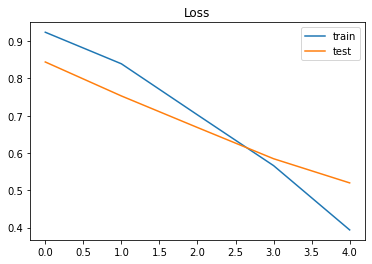

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

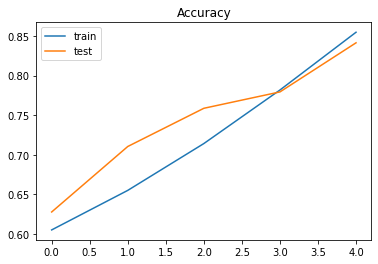

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();